# Exploratory Data Analysis

In this notebook I am exploring the data as such: 

### 1. EDA
For the EDA of this project I decided to have a look at the overall social media footprint of the personas and I tried to answer these apparently simple questions: 

* 1.1. How much do they tweet? When? How do their Tweets look like?
* 1.2. How is the overall popularity of these social media icons? What is their Likes, Retweets, Hashtags, At Mentions and Emojis usage? 
* 1.3. How are these metrics linked to each other?

The idea was to understand if there was anything in particular that could be hinted as a driver to further classify the persona talking and which insights I could gather from this analysis. 

*** 

### 2. Sentiment Scoring

Additionally in the EDA I have looked at the **Sentiment Scoring** and tried to understand if there were differences in the type of words used in positive/negative tweets, depending on the Twitter account tweeting. 

***

### 3. Sampling

Lastly, in the EDA I have down-sampled the dataset, in such way that each persona is probable to tweet. By **down-sampling**, however, I had to drop one of the 5 personas analyzed so far: the Pontifex. Indeed, despite the Pope had a very well articulated speech, his dataset was too light and limited in number. I did not want to down-sample the remaining 4 personas to approximately 3K tweets each. 

By removing the Pope, the smallest sample was coming from Biden, hence I decided to down-sample Trum, Kim Kardashian and Elon Musk to 6K tweets. I have done a random sampling to this purpose. 

I decided to use this approach as it was the most convenient to use and I thought it was the most stable. I could have, on the other side, left the dataset unbalanced, but I was fearing that modelling would have given fuzzy results risking overfitting. I could also have done a up-sampling of Biden's tweets, but I decided that this would have incurred also in problems when modelling. I could be investigating this in the future, in any case. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import OrderedDict
import scipy as sc
import re
from pprint import pprint
import sys
from ast import literal_eval

# Sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Nltk 
import nltk
from nltk.corpus import stopwords

# Spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from IPython.display import Image

In [2]:
# reading dataset 
df = pd.read_csv('final_dataset.csv')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1,2,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# transforming date into datetime
df = df[df.date != 'date']
df.date = pd.to_datetime(df.date)

In [4]:
# creating some useful columns to explore data in time series way
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['weekday'] = pd.DatetimeIndex(df['date']).weekday
df['hour'] = pd.DatetimeIndex(df['date']).hour

In [5]:
# transforming likes and retweets into integers 
df.likes = df.likes.astype('float')
df.retweets = df.retweets.astype('float')
df.likes = df.likes.astype('int32')
df.retweets = df.retweets.astype('int32')

In [6]:
# missing data overview
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).head(5)
missing_data

,Total,Percent
emojis,88287,0.953856
final,3150,0.034033
cleaned,3150,0.034033
hour,0,0.000000
num_hashtags,0,0.000000


It is okay that we do not have emojis in all the dataset and when it comes to "cleaned" and "final" I will have to drop these null values (as a consequence of the cleaning for emojis, punctuation, hashtags, websites, mentions etc).

In [7]:
# setting up some smaller dfs in case of need
trump = df[df.persona == 'trump']
kim = df[df.persona == 'kim']
bid = df[df.persona == 'bid']
pope = df[df.persona == 'pope']
elon = df[df.persona == 'elon']

# 1. Exploratory Data Analysis

## 1.1 How much do personas tweet? When? How do their Tweets look like?

In [8]:
# checking the total size of tweets
print('Dataset Total Size - Total number of Tweets in database:', len(df))

Dataset Total Size - Total number of Tweets in database: 92558


  persona  tweet_id
0   trump     45077
1     kim     27280
2    elon     11287
3   biden      6037
4    pope      2877


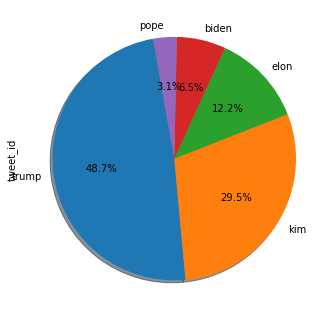

In [9]:
# data overview per persona
overview = df.groupby('persona')['tweet_id'].count().sort_values(ascending = False).to_frame().reset_index()

plt.figure(figsize=(12,8))
# plot chart
ax1 = plt.subplot(121, aspect='equal')
overview.plot(kind='pie', 
              y = 'tweet_id', 
              ax=ax1, 
              autopct='%1.1f%%', 
              shadow = True, 
              labels = overview['persona'], 
              legend = False, 
              fontsize=10, 
              startangle=100)

print(overview)

Clearly we can see that the dataset is quite unbalanced. 

The dataset consists of **historical Twitter data** I was able to scrape from Twitter for each of the personas (except for Trump for who I retrieved Tweets from the Trump Twitter Archive). We can conclude that the distribution of Tweets is really reflecting the patterns of communication between personas. 

Let's now have a look at the distribution overtime of tweets and how much over time our social media icons have been tweeting.

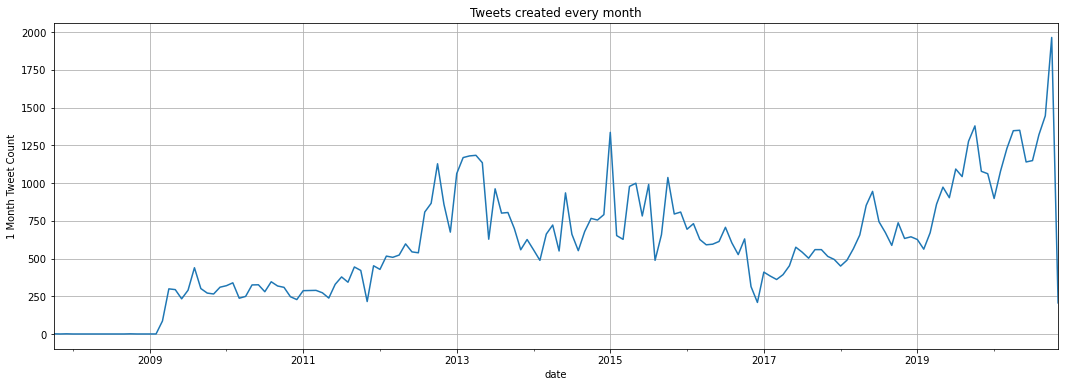

In [10]:
# general view of tweets published overall 
tweet_df_1mon = df.groupby(pd.Grouper(key='date', freq='1M')).size()
tweet_df_1mon.plot(figsize=(18,6))
plt.ylabel('1 Month Tweet Count')
plt.title('Tweets created every month')
plt.grid(True)

Text(0.5, 1.0, 'Tweets created every month per Persona')

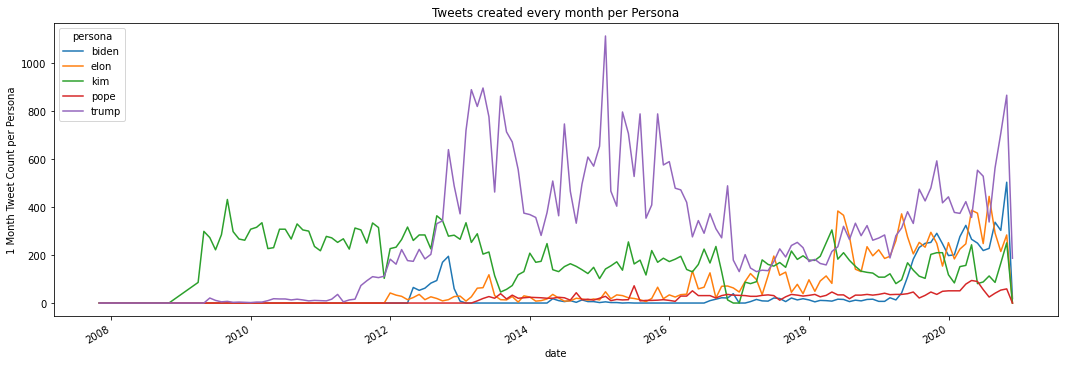

In [11]:
# view of tweets published over time per persona
df_time = pd.DataFrame(df.set_index('date').groupby([pd.Grouper(freq='1M'), 'persona']).tweet_id.count())
df_time.reset_index(inplace = True)
df_time.set_index('date')
df_time = df_time.pivot(index='date', columns='persona', values='tweet_id')
df_time.fillna(0, inplace = True)
df_time.plot(figsize=(18,6))
plt.ylabel('1 Month Tweet Count per Persona')
plt.title('Tweets created every month per Persona')

We can see that Kim has been a very high user of the social media, way before the other users, already in 2009. She has always kept her tweeting pace throughout the years.

Trump has been rocketing around 2015 and 2016 (just before his election, what a surprise!), have been "silent" during his mandate, but around 2019 and 2020 has been rocketing once more (for his second mandate). 

Similarly to Trump, Biden had a tweeting peak at the end of 2019 and 2020 - in his campaign trail, but his magnitude of Tweets hasn't been as prolific as his political opponent. 

Elon has started tweeting a with a more solid pace in the past 2 years (from 2018). 

As for the Pope, we can see that his tweeting pace has always been constant. 

In [12]:
# mean of words, characters and upper words used 
words = df[['persona', 'total_words', 'total_charact', 'num_upper_words']].copy()
words.groupby('persona')[['total_words', 'total_charact', 'num_upper_words']].mean().round(1).reset_index()

,persona,total_words,total_charact,num_upper_words
0,biden,30.1,185.3,0.2
1,elon,13.7,90.9,0.2
2,kim,12.5,81.9,0.5
3,pope,24.3,136.6,0.0
4,trump,19.7,127.4,0.6


We can see that on average Biden and the Pope are using more **Total words**, to indicate that they have a much more articulated Tweets, compared to Kim and Trump. 

The variable **Total characters** is in line with what we have just found when it comes to the speech articulation of Biden/Pope. These 2 have the highest total characters, however I find this variable not very informative at this point because it includes also punctuation, websites references, emojis, special characters etc. It is interesting how Trump actually does not use many words, but the total_carachters are almost at parity with the Pope, meaning that Trump is an extensive user of either special characters, at mentions, hashtags or punctuation. 

The big surprise comes when we have **Upper words**! Trump is leading this category with an average of 0.6 words per tweet being in capital letters! This is clearly indicative of his tone of voice. Kim, surprisingly, is also not a big fan of the netiquette and ALWAYS SEEMS SCREAMING IN HER POSTS!

Now, let's take a look at the publishing habits per **day of the week** per persona.

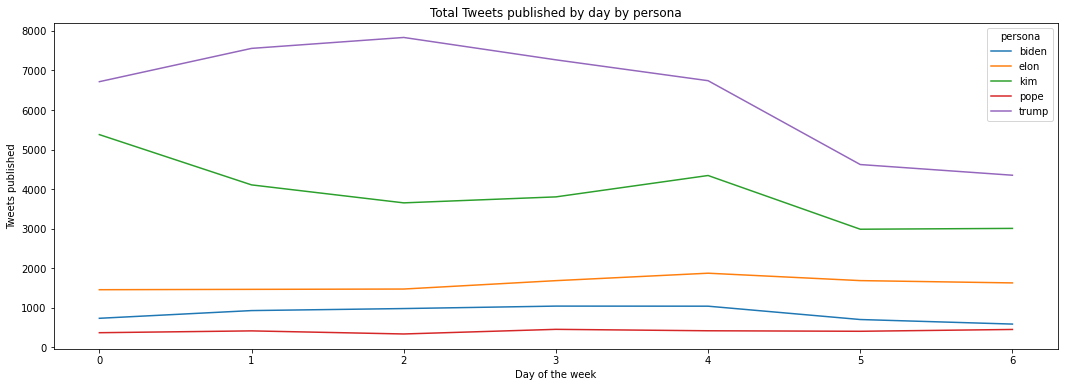

In [13]:
# total tweets published by day of the week per persona
df_wd_persona = pd.DataFrame(df.groupby(['weekday', 'persona']).tweet_id.count()).reset_index()
df_wd_persona = df_wd_persona.set_index('weekday')
df_wd_persona = df_wd_persona.pivot(columns='persona', values='tweet_id')
df_wd_persona.fillna(0, inplace = True)
df_wd_persona.plot(figsize=(18,6), x_compat=True)
plt.ylabel('Tweets published')
plt.title('Total Tweets published by day by persona')
plt.xticks(np.arange(0, 7, 1))
plt.xlabel('Day of the week')
plt.show()

I have tried to look at wether there was a specific day for the 5 personas to use Twitter the most (e.g. I was expecting the Pope to be productive on Sundays), but it turned out there is **not much difference** between tweeting habits. 

Let's deep dive into the **hours of the day** to see if there are any publishing differences across personas.

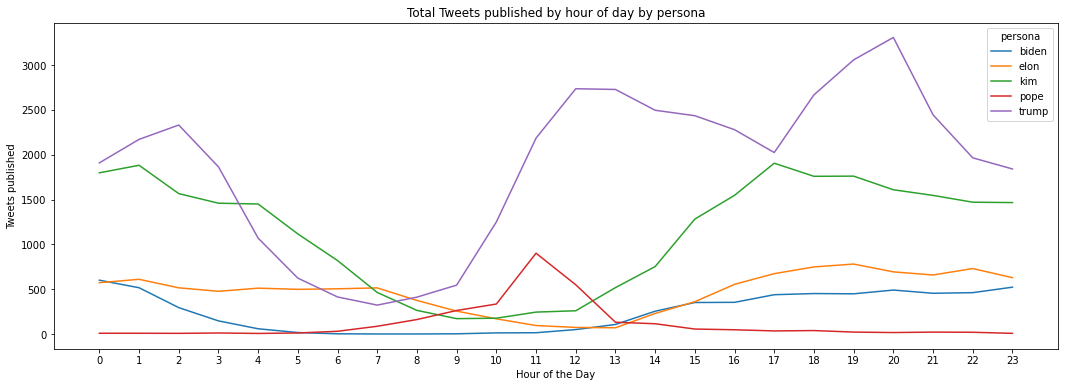

In [14]:
# total tweets published by hour per persona
df_hour_persona = pd.DataFrame(df.groupby(['hour', 'persona']).tweet_id.count()).reset_index()
df_hour_persona = df_hour_persona.set_index('hour')
df_hour_persona = df_hour_persona.pivot(columns='persona', values='tweet_id')
df_hour_persona.fillna(0, inplace = True)
df_hour_persona.plot(figsize=(18,6), x_compat=True)
plt.ylabel('Tweets published')
plt.title('Total Tweets published by hour of day by persona')
plt.xticks(np.arange(0, 24, 1))
plt.xlabel('Hour of the Day')
plt.show()

On the contrary, there are some patterns in the **time of posting**. Overall, Trup seems tweeting mostly in the second part of the day, towards the evening, same as Kim. The Pope on the other hand, has time during lunch time (peaking at 11AM).The other personas does not have a specific and preferred timeframe to post. 

## 1.2. How is the overall popularity of these social media icons?

In [15]:
sum = df.groupby('persona')[['likes',
                              'retweets',
                              'num_hashtags',
                              'num_mentions', 
                              'num_emojis',
                              'num_upper_words']].sum().round(2).reset_index()


In [16]:
sum

,persona,likes,retweets,num_hashtags,num_mentions,num_emojis,num_upper_words
0,biden,212323939,38633192,849,1057,28,1369
1,elon,196248380,22974582,46,15929,1188,2360
2,kim,192232038,28762611,4485,14021,5567,13391
3,pope,68437280,19691543,1040,28,0,98
4,trump,1394671289,325478541,7320,40800,811,28386


In [17]:
mean = df.groupby('persona')[['likes',
                              'retweets',
                              'num_hashtags',
                              'num_mentions', 
                              'num_emojis',
                              'num_upper_words']].mean().round(2).reset_index()

median = df.groupby('persona')[['likes',
                              'retweets']].median().round(0).reset_index()

In [18]:
mean

,persona,likes,retweets,num_hashtags,num_mentions,num_emojis,num_upper_words
0,biden,35170.44,6399.40,0.14,0.18,0.00,0.23
1,elon,17387.12,2035.49,0.00,1.41,0.11,0.21
2,kim,7046.63,1054.35,0.16,0.51,0.20,0.49
3,pope,23787.72,6844.47,0.36,0.01,0.00,0.03
4,trump,30939.75,7220.50,0.16,0.91,0.02,0.63


The preliminary absolute results on the total sum of Likes/Retweets/Hashtags etc is not very informative. 
The mean is already giving better insights. 

Let's deep dive one by one these **metrics of 'popularity'** on Twitter! I am sure we are going to find some very nice insights and we will be able to answer the question "who has the best social media manager"???

## 1.2.1. Likes

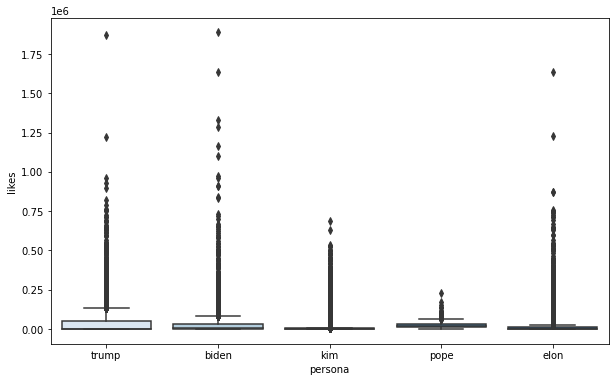

In [19]:
# distribution of likes of personas 
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["persona"], y=df["likes"], palette="Blues")

We can see that, in absolute terms, the distribution of likes is very wide-spread for almost all the personas, except for Kim and the Pope, which have a more concentrated distribution of likes. This means that the other 3 personas (Trump, Biden and Elon) are tweeting some very polarizing content which receives incredible amount of likes. 

Let's see the how the personas vary over the **average of likes**. 

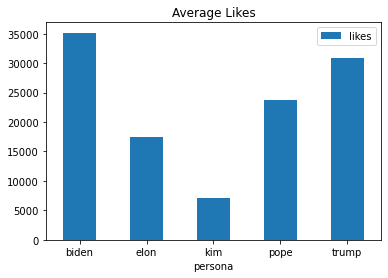

  persona    likes
0   biden  35170.4
1    elon  17387.1
2     kim   7046.6
3    pope  23787.7
4   trump  30939.8


In [20]:
# distribution of mean of likes per persona 
mean.plot.bar(x='persona', y='likes', rot=0)
plt.title("Average Likes")
plt.show()
print(mean[['persona', 'likes']].round(1))

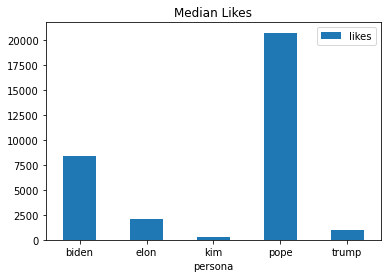

  persona    likes
0   biden   8363.0
1    elon   2059.0
2     kim    298.0
3    pope  20725.0
4   trump   1008.0


In [21]:
# distribution of median of likes per persona 
median.plot.bar(x='persona', y='likes', rot=0)
plt.title("Median Likes")
plt.show()
print(median[['persona', 'likes']])

We can see that if we look at the **average of likes** per total tweets posted by each user, Biden obtains by far a higher average on Likes (35K)! It is followed closely by Trump (31K) and the Pope (23K). Kim, who is alleged to be a very popular icon among the four is, unexpectedly, receiving less likes from her audience.

This result, however might be misleading. If we in fact look at the **median of Likes** we can see that the Pope has by far more likes than the other social media icons. 

However, this result is a bit biased. 

Once more, even after having taken a look at the median, I am still puzzled about the **frequency of posting**. 

Indeed if I post a lot, I might get the chance to do jackpot with one post very liked but my mean would be polluted among the ocean of posts I have tweeted. 

If we think about the Pope, he is not posting at the same ratio of Trump/Kim, meaning that whenever he speaks he gets automatically some attention of his audience and he is getting more likes (at least, this is my theory). 

There is only one way to check it and it is by doing the mean of likes per tweet, per person, in a specific timeframe (e.g. tweets per month). 

Text(0.5, 1.0, 'Tweets liked every month per Persona')

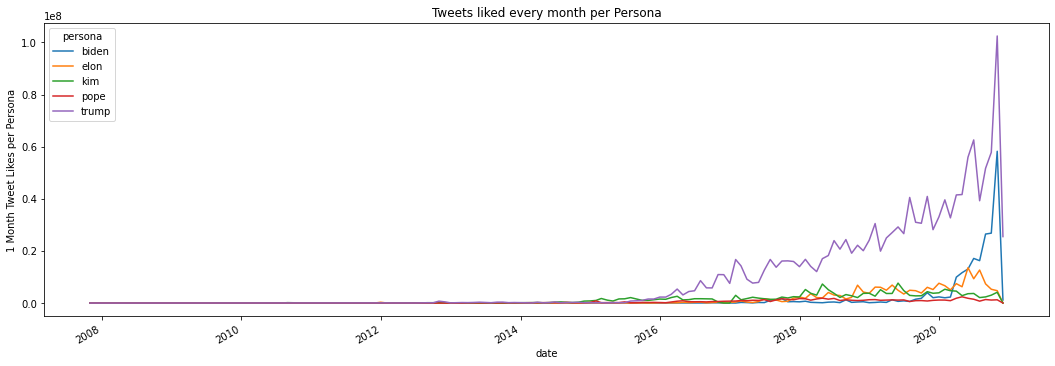

In [22]:
# Tweets liked every month per persona
df_likes = pd.DataFrame(df.set_index('date').groupby([pd.Grouper(freq='1m'), 'persona']).likes.sum())
df_likes.reset_index(inplace = True)
df_likes.set_index('date')
df_likes = df_likes.pivot(index='date', columns='persona', values='likes')
df_likes.fillna(0, inplace = True)
df_likes.plot(figsize=(18,6))
plt.ylabel('1 Month Tweet Likes per Persona')
plt.title('Tweets liked every month per Persona')

Doing the mean of likes per tweet, per person, in a specific timeframe (e.g. tweets per month). 

In [23]:
likes_p_year = df.groupby(['year','month', 'persona'])[['likes']].sum()
likes_p_year['total_tweets'] = df.groupby(['year', 'month', 'persona'])[['likes']].count()
likes_p_year['likes_tweet'] = (likes_p_year.likes) / (likes_p_year.total_tweets)
likes_p_year.reset_index(inplace = True)
likes_p_year['date'] = pd.to_datetime(likes_p_year[['year', 'month']].assign(DAY=1))

In [24]:
likes_p_year

,year,month,persona,likes,total_tweets,likes_tweet,date
0,2007,10,biden,36,1,36.000000,2007-10-01
1,2007,12,biden,38,1,38.000000,2007-12-01
2,2008,10,kim,28,1,28.000000,2008-10-01
3,2009,3,kim,29691,86,345.244186,2009-03-01
4,2009,4,kim,26968,299,90.193980,2009-04-01
...,...,...,...,...,...,...,...
548,2020,10,kim,4132807,251,16465.366534,2020-10-01
549,2020,10,pope,1243607,59,21078.084746,2020-10-01
550,2020,10,trump,102463342,867,118181.478662,2020-10-01
551,2020,11,biden,1161349,19,61123.631579,2020-11-01


Text(0.5, 1.0, 'Distribution of Likes Over Tweets per month over the past years')

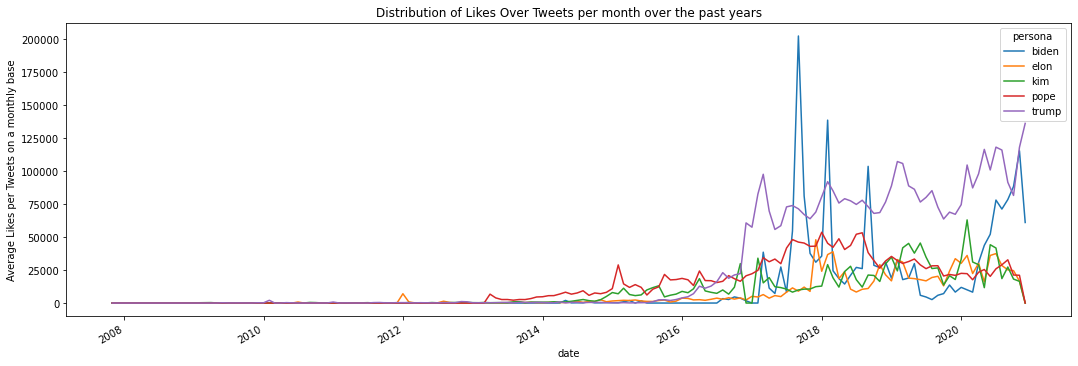

In [25]:
# distribution of Likes over Tweets per month over the past years
df_lpy = pd.DataFrame(likes_p_year.set_index('date').groupby([pd.Grouper(freq='M'), 'persona']).likes_tweet.sum())
df_lpy.reset_index(inplace = True)
df_lpy.set_index('date')
df_lpy = df_lpy.pivot(index='date', columns='persona', values='likes_tweet')
df_lpy.fillna(0, inplace = True)
df_lpy.plot(figsize = (18,6))
plt.ylabel('Average Likes per Tweets on a monthly base')
plt.title('Distribution of Likes Over Tweets per month over the past years')

It looks like Trump has been creating a solid base of constant engagement (Likes) over his tweets in the past 3-4 years, whereas Biden has been gaining attrition only for specific posts. For the other personas, nothing is striking and needs to be remarked.

I will be now focusing on Retweets. 

## 1.2.2. Retweets

I will be using the same approach I used for Likes for Retweets below. 

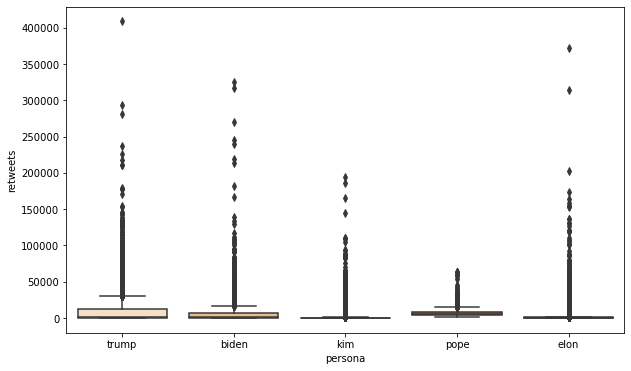

In [26]:
# distribution of retweets of personas 
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["persona"], y=df["retweets"], palette="Oranges")

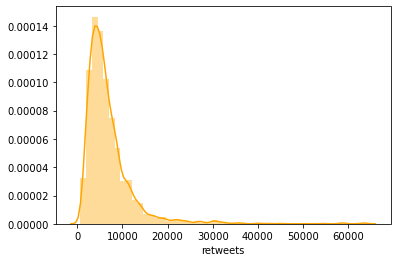

In [27]:
# The Pope distibution of retweets
sns.distplot(df[df.persona == 'pope'].retweets, color = 'orange')

Similarly to the Likes, the Retweets are also showing a similar pattern: Kim Kardashian and the Pope have a more concentrated distribution of Retweets, whereas the other Personas have quite a few polarizing response for some posts!

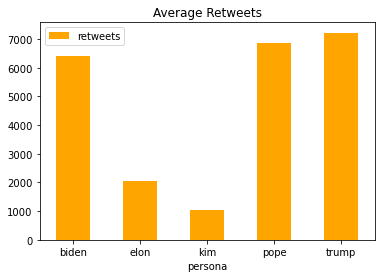

  persona  retweets
0   biden   6399.40
1    elon   2035.49
2     kim   1054.35
3    pope   6844.47
4   trump   7220.50


In [28]:
# distribution of mean of retweets per persona 
mean.plot.bar(x='persona', y='retweets', rot=0, color = 'orange')
plt.title("Average Retweets")
plt.show()
print(mean[['persona', 'retweets']])

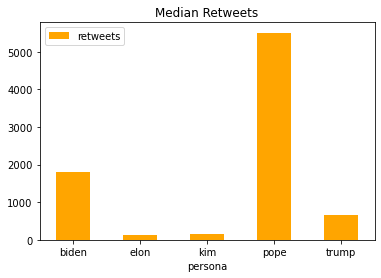

  persona  retweets
0   biden    1806.0
1    elon     132.0
2     kim     154.0
3    pope    5507.0
4   trump     659.0


In [29]:
# distribution of median of retweets per persona 
median.plot.bar(x='persona', y='retweets', rot=0, color = 'orange')
plt.title("Median Retweets")
plt.show()
print(median[['persona', 'retweets']])

The second 'popularity' assessment, the **retweets**, also indicates that even though the posts of the Pope are less liked (3rd position in the ranking for 'Likes'), he is actually gaining a lot of retweeted content by his targets. 

We can clearly see that Biden, Trump and the Pope are in the podium. Kim is really the tail light of the personas here - she is getting very little retweets on average (is it because she spams a lot?).


Text(0.5, 1.0, 'Tweets Retweeted every month per Persona')

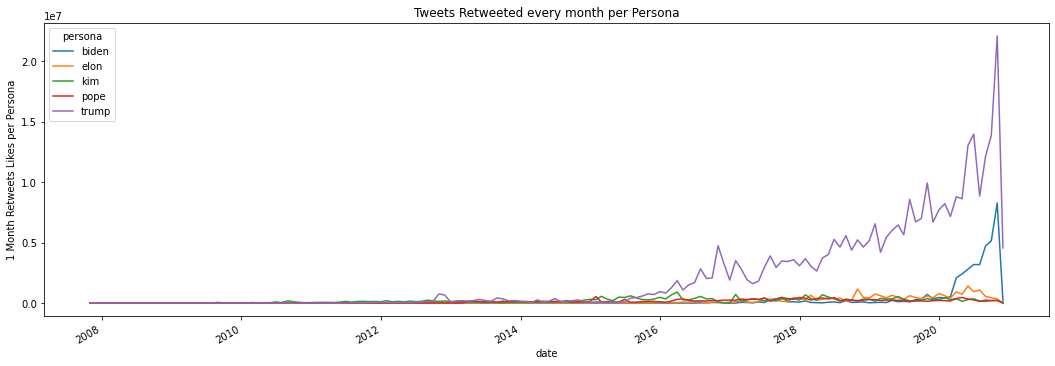

In [30]:
# tweets retweeted every month per persona
df_ret = pd.DataFrame(df.set_index('date').groupby([pd.Grouper(freq='1m'), 'persona']).retweets.sum())
df_ret.reset_index(inplace = True)
df_ret.set_index('date')
df_ret = df_ret.pivot(index='date', columns='persona', values='retweets')
df_ret.fillna(0, inplace = True)
df_ret.plot(figsize=(18,6))
plt.ylabel('1 Month Retweets Likes per Persona')
plt.title('Tweets Retweeted every month per Persona')

Very very interesting! There seems to be a **correlation between the tweets that are liked and being retweeted**!
Indeed the trend and the spikes look suspiciously very similar. I will need to investigate this further!

In [31]:
rt_p_year = df.groupby(['year','month', 'persona'])[['retweets']].sum()
rt_p_year['total_tweets'] = df.groupby(['year', 'month', 'persona'])[['retweets']].count()
rt_p_year['rt_tweet'] = (rt_p_year.retweets) / (rt_p_year.total_tweets)
rt_p_year.reset_index(inplace = True)
rt_p_year['date'] = pd.to_datetime(rt_p_year[['year', 'month']].assign(DAY=1))

In [32]:
rt_p_year

,year,month,persona,retweets,total_tweets,rt_tweet,date
0,2007,10,biden,9,1,9.000000,2007-10-01
1,2007,12,biden,21,1,21.000000,2007-12-01
2,2008,10,kim,36,1,36.000000,2008-10-01
3,2009,3,kim,26057,86,302.988372,2009-03-01
4,2009,4,kim,19294,299,64.528428,2009-04-01
...,...,...,...,...,...,...,...
548,2020,10,kim,203354,251,810.175299,2020-10-01
549,2020,10,pope,220133,59,3731.067797,2020-10-01
550,2020,10,trump,22072186,867,25458.115340,2020-10-01
551,2020,11,biden,160199,19,8431.526316,2020-11-01


Text(0.5, 1.0, 'Distribution of Retweets Over Tweets per month over the past years')

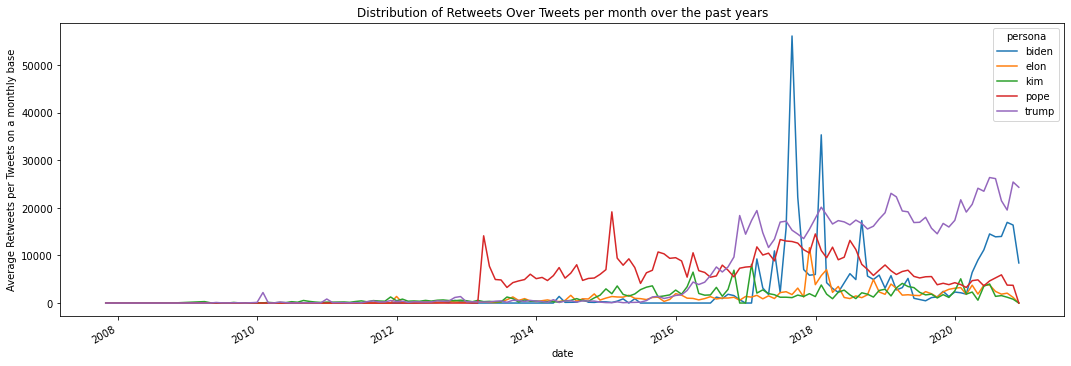

In [33]:
# distribution of retweets over tweets per month over the past years per persona
df_rpy = pd.DataFrame(rt_p_year.set_index('date').groupby([pd.Grouper(freq='M'), 'persona']).rt_tweet.sum())
df_rpy.reset_index(inplace = True)
df_rpy.set_index('date')
df_rpy = df_rpy.pivot(index='date', columns='persona', values='rt_tweet')
df_rpy.fillna(0, inplace = True)
df_rpy.plot(figsize = (18,6))
plt.ylabel('Average Retweets per Tweets on a monthly base')
plt.title('Distribution of Retweets Over Tweets per month over the past years')

As seen previously, we can see that Trump has been working on his social audience and its engagement constantly over the past years (continuous increment of Retweets over time).  

Biden, on the contrary, has obtained some spikes in the engagement (retweets) on very specific periods of year. 

Interestingly, the Pontifex retweets have been decreasing in the past 2 years, compared to its start. 

## 1.2.3. Hasthags

In [34]:
total = df.groupby('persona')[['likes',
                              'retweets',
                              'num_hashtags',
                              'num_mentions', 
                              'num_emojis',
                              'num_upper_words']].sum().reset_index()

total[['persona', 'num_hashtags']]

,persona,num_hashtags
0,biden,849
1,elon,46
2,kim,4485
3,pope,1040
4,trump,7320


In absolute terms, it looks like Trump is the highest user of Hashtags. When we look at the distribution of hashtags , we can see that the Pope has hactually the habit of using hashtags in his tweets as he is often using at least 1 hashtag. 

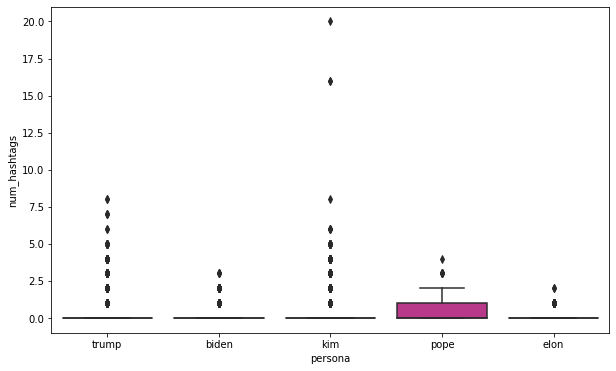

In [35]:
# distribution of hashtags per personas 
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["persona"], y=df["num_hashtags"], palette="RdPu")

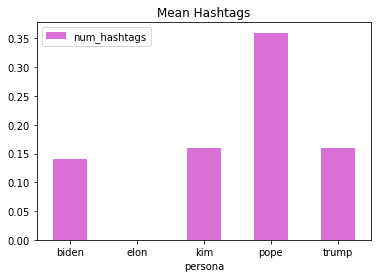

  persona  num_hashtags
0   biden          0.14
1    elon          0.00
2     kim          0.16
3    pope          0.36
4   trump          0.16


In [36]:
# distribution of mean of hashtags per persona 
mean.plot.bar(x='persona', y='num_hashtags', rot=0, color = 'orchid')
plt.title("Mean Hashtags")
plt.show()
print(mean[['persona', 'num_hashtags']])

When it comes to **hashtags average usage** per post, to my surprise, the Pope has the podium! This is worth a bit of investigation, as I was expecting the Tv show model to be heavily using them.

In [37]:
# extracting number of hashtags from the list of hashtags
df.loc[:,'hashtag'] = df.loc[:,'hashtag'].apply(lambda x: literal_eval(x))
list_of_lists = df['hashtag'].to_list()
flattened = [val for sublist in list_of_lists for val in sublist]

In [38]:
# number of unique hashtags across personas 
len(list(set(flattened)))

4929

In [39]:
# creating a common dictionary across all hashtags used
unique_hash = list(set(flattened))
d = {i: 0 for i in unique_hash}
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse = True )}

In [40]:
for i in df.hashtag: 
    if len(i)>0: 
        for j in i: 
            d[j] += 1

In [41]:
# creating a dictionary per persona  
d_trump = {i: 0 for i in unique_hash}
d_kim = {i: 0 for i in unique_hash}
d_bid = {i: 0 for i in unique_hash}
d_pope = {i: 0 for i in unique_hash}
d_elon = {i: 0 for i in unique_hash}

In [42]:
for i in df.query('persona == "trump"')['hashtag']:
    if len(i)>0: 
        for j in i: 
            d_trump[j] += 1
            
            
top_hash_trump = {k: v for k, v in sorted(d_trump.items(), key=lambda item: item[1], reverse = True )[:100]}
trump_10_hashtags = pd.DataFrame.from_dict(top_hash_trump, orient = 'index').head(10)

In [43]:
for i in df.query('persona == "kim"')['hashtag']:
    if len(i)>0: 
        for j in i: 
            d_kim[j] += 1

            
top_hash_kim = {k: v for k, v in sorted(d_kim.items(), key=lambda item: item[1], reverse = True)[:30]}
kim_10_hashtags = pd.DataFrame.from_dict(top_hash_kim, orient = 'index').head(10)

In [44]:
for i in df.query('persona == "pope"')['hashtag']:
    if len(i)>0: 
        for j in i: 
            d_pope[j] += 1
            

top_hash_pope = {k: v for k, v in sorted(d_pope.items(), key=lambda item: item[1], reverse = True)[:30]}
pope_10_hashtags = pd.DataFrame.from_dict(top_hash_pope, orient = 'index').head(10)

In [45]:
for i in df.query('persona == "elon"')['hashtag']:
    if len(i)>0: 
        for j in i: 
            d_elon[j] += 1
            

top_hash_elon = {k: v for k, v in sorted(d_elon.items(), key=lambda item: item[1], reverse = True)[:30]}
elon_10_hashtags = pd.DataFrame.from_dict(top_hash_elon, orient = 'index').head(10)

In [46]:
for i in df.query('persona == "biden"')['hashtag']:
    if len(i)>0: 
        for j in i: 
            d_bid[j] += 1
            
            
top_hash_bid = {k: v for k, v in sorted(d_bid.items(), key=lambda item: item[1], reverse = True)[:30]}
bid_10_hashtags = pd.DataFrame.from_dict(top_hash_bid, orient = 'index').head(10)

Text(0.5, 1.0, 'Most Used Hashtags - Elon')

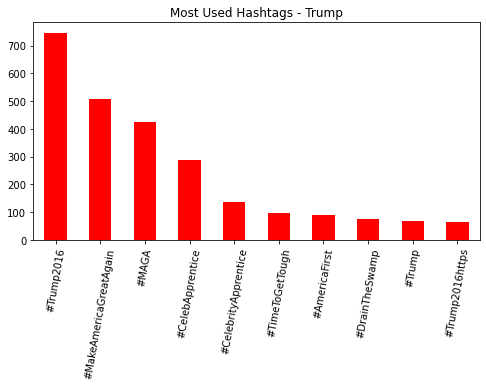

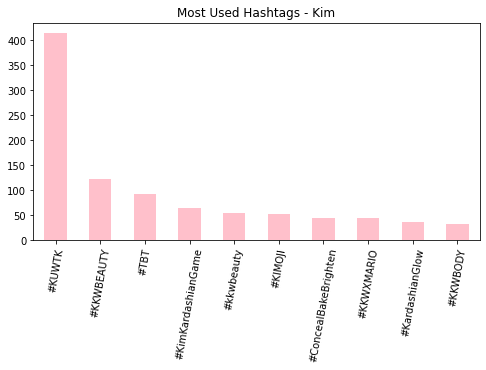

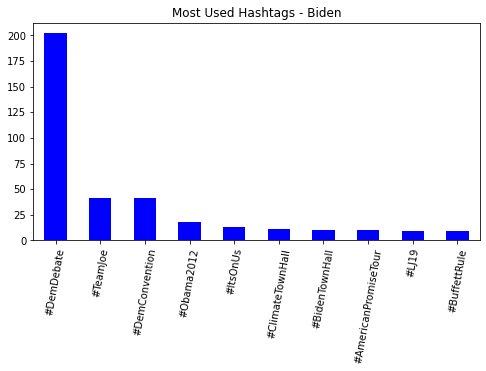

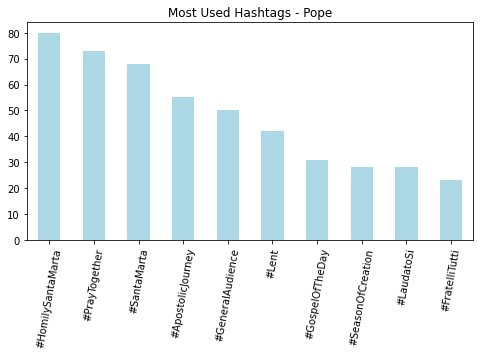

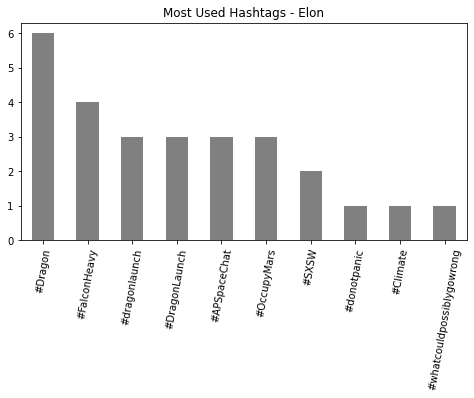

In [47]:
fig_trump = trump_10_hashtags.plot.bar(color = 'red', legend = None, figsize=(8,4))
plt.xticks(fontsize=10, rotation=80)
plt.title("Most Used Hashtags - Trump")

fig_kim = kim_10_hashtags.plot.bar(color = 'pink', legend = None, figsize=(8,4))
plt.xticks(fontsize=10, rotation=80)
plt.title("Most Used Hashtags - Kim")

fig_bid = bid_10_hashtags.plot.bar(color = 'blue', legend = None, figsize=(8,4))
plt.xticks(fontsize=10, rotation=80)
plt.title("Most Used Hashtags - Biden")

fig_pope = pope_10_hashtags.plot.bar(color = 'lightblue', legend = None, figsize=(8,4))
plt.xticks(fontsize=10, rotation=80)
plt.title("Most Used Hashtags - Pope")

fig_elon = elon_10_hashtags.plot.bar(color = 'gray', legend = None, figsize=(8,4))
plt.xticks(fontsize=10, rotation=80)
plt.title("Most Used Hashtags - Elon")

It is very interesting to see the difference in hashtags used by the personas. 

* The Pontifex has a clear tendence towards holy content (#HomilySantaMarta, #PrayTogether)
* Trump and Biden over political/environmental/governmental subjects (#DemDebate, #Trump2016, #MAGA)
* Kim is reflecting her tv shows (Keping up with the Kardashians #KUWTK, #KUWTKBEAUTY)
* Elon is using hashtags related to space X and his spatial projects (#Dragon, #FalconHeavy)




## 1.2.4. Mentions

In [48]:
# total number of mentions per persona
total[['persona', 'num_mentions']]

,persona,num_mentions
0,biden,1057
1,elon,15929
2,kim,14021
3,pope,28
4,trump,40800


I am not going to investigate neither the Pope nor Biden in detail as they do not have as much richness as Trump, Kim and Elon on the @mentions. Overall in absolute terms, it really looks like Trump is on fire! He is abusing of the @mentions. Is this a strenght of his political tone of voice? Let's deep dive and look at the **distribution** of the @mentions usage per persona. 

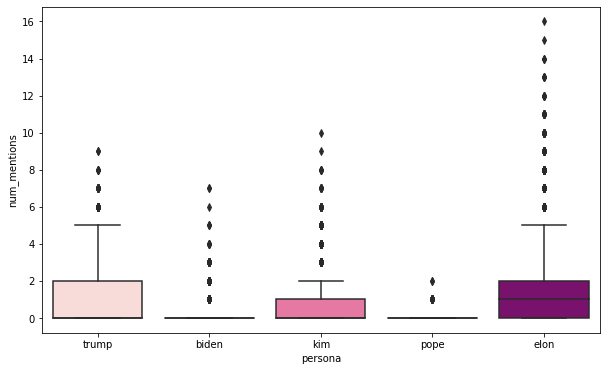

In [49]:
# distribution of at mentions of personas 
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["persona"], y=df["num_mentions"], palette="RdPu")

We can see that Trump and Elon are often users of @mentions, but Trump has a much more condesed distribution (Elon is widespread). 

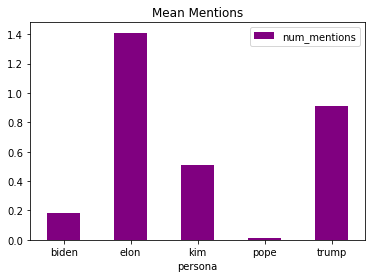

  persona  num_mentions
0   biden          0.18
1    elon          1.41
2     kim          0.51
3    pope          0.01
4   trump          0.91


In [50]:
# distribution of mean of at mentions used per persona 
mean.plot.bar(x='persona', y='num_mentions', rot=0, color = 'purple')
plt.title("Mean Mentions")
plt.show()
print(mean[['persona', 'num_mentions']])

Clearly we can see that the Pope, even though he is really a heavy user of hasthags, is not @mentioning anyone!

On the contrary, Elon is leading in this domain. This could be especially true when it comes to the fact that the entrepreneur could have used at mentions to gain more visibility and opportunity to be seen on social. 

Let's take a closer look to the @mentions. 

In [51]:
# extracting number of mentions from the list of mentions
df.loc[:,'mentions'] = df.loc[:,'mentions'].apply(lambda x: literal_eval(x))
list_of_lists_m = df['mentions'].to_list()
flattened_m = [val for sublist in list_of_lists_m for val in sublist]

In [52]:
# number of unique mentions across personas 
len(list(set(flattened_m)))

23752

In [53]:
# creating a common dictionary across all hashtags used
unique_hash_m = list(set(flattened_m))

In [54]:
# creating a dictionary per persona  
d_trump_m = {i: 0 for i in unique_hash_m}
d_kim_m = {i: 0 for i in unique_hash_m}
d_elon_m = {i: 0 for i in unique_hash_m}

In [55]:
for i in df.query('persona == "trump"')['mentions']:
    if len(i)>0: 
        for j in i: 
            d_trump_m[j] += 1
            
top_mentions_trump = {k: v for k, v in sorted(d_trump_m.items(), key=lambda item: item[1], reverse = True )[:30]}
trump_10_mentions = pd.DataFrame.from_dict(top_mentions_trump, orient = 'index').head(10).reset_index()
trump_10_mentions.columns = [['persona', 'count']]

In [56]:
for i in df.query('persona == "kim"')['mentions']:
    if len(i)>0: 
        for j in i: 
            d_kim_m[j] += 1
            
top_mentions_kim = {k: v for k, v in sorted(d_kim_m.items(), key=lambda item: item[1], reverse = True )[:30]}
kim_10_mentions = pd.DataFrame.from_dict(top_mentions_kim, orient = 'index').head(10).reset_index()
kim_10_mentions.columns = [['persona', 'count']]

In [57]:
for i in df.query('persona == "elon"')['mentions']:
    if len(i)>0: 
        for j in i: 
            d_elon_m[j] += 1
            
top_mentions_elon = {k: v for k, v in sorted(d_elon_m.items(), key=lambda item: item[1], reverse = True )[:30]}
elon_10_mentions = pd.DataFrame.from_dict(top_mentions_elon, orient = 'index').head(10).reset_index()
elon_10_mentions.columns = [['persona', 'count']]

In [58]:
kim_10_mentions

,persona,count
0,@KimKardashian,561
1,@KhloeKardashian,530
2,@kkwbeauty,422
3,@KourtneyKardash,310
4,@RobKardashian,233
5,@JonathanCheban,231
6,@khloekardashian,178
7,@BrittGastineau,171
8,@kimkardashian,164
9,@skims,141


In [59]:
trump_10_mentions

,persona,count
0,@realDonaldTrump,8287
1,@FoxNews,806
2,@BarackObama,731
3,@foxandfriends,612
4,@ApprenticeNBC,388
5,@CNN,368
6,@MittRomney,316
7,@IvankaTrump,187
8,@seanhannity,182
9,@nytimes,180


In [60]:
elon_10_mentions

,persona,count
0,@Tesla,643
1,@Erdayastronaut,538
2,@flcnhvy,401
3,@SpaceX,394
4,@PPathole,216
5,@Teslarati,199
6,@teslaownersSV,193
7,@cleantechnica,132
8,@Kristennetten,126
9,@thirdrowtesla,125


At first I was a bit surprised that Elon, Kim and Trump were @mentioning themselves. I found it bizzarre and very autoreferential, but then I went online to investigate if this is actually a **good practice to enhance the visibility of the posts**. 

I actually found that at mentioning yourself gives you the possibility of seeing who is retweeting the content and also gives a good opportunity to **connect with this audience**. 

It also gives the people who see the tweet being at mentioned a fast way to **find the Twitter profile** and connect/start following. 

This practice falls into the **"free advertising"** that you can do to your Twitter account to be very active on social networks and properly promoting yourself. In this, Trump, Elon and Kim are clearly champions!


## 1.2.5. Emojis

In [61]:
# total number of mentions per persona
total[['persona', 'num_emojis']]

,persona,num_emojis
0,biden,28
1,elon,1188
2,kim,5567
3,pope,0
4,trump,811


We can see that the absolute winner of the Emoji contest is Kim! She has by far a highest usage of emojis compared to the other personas. Kim is undisputably the Queen of Emojis! Trump is using some, but in a very diluted way. The Pontifex does not use emojis at all (is it because they are not serious enough or there aren't sufficient religious-inspired emojis?).

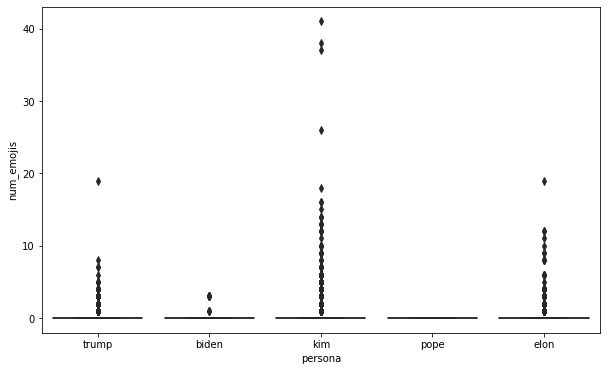

In [62]:
# distribution of emojis per personas 
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["persona"], y=df["num_emojis"], palette="Greens")

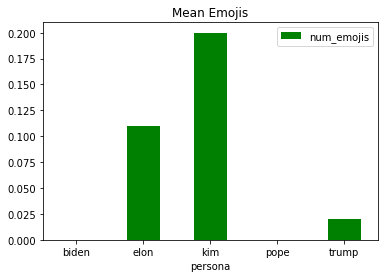

  persona  num_emojis
0   biden        0.00
1    elon        0.11
2     kim        0.20
3    pope        0.00
4   trump        0.02


In [63]:
# distribution of mean of emojis per persona
mean.plot.bar(x='persona', y='num_emojis', rot=0, color = 'green')
plt.title("Mean Emojis")
plt.show()
print(mean[['persona', 'num_emojis']])

As just identified, Kim is the Queen of emojis. Interestingly Elon is also not weak in this domain!

In [64]:
# dropping null emojis
kim_emo = df[df.persona == 'kim'].copy()
kim_emo.emojis.dropna(inplace = True)

elon_emo = df[df.persona == 'elon'].copy()
elon_emo.emojis.dropna(inplace = True)

In [65]:
# making emojis list
list_of_lists_emo_kim = kim_emo['emojis'].to_list()
flattened_emo_kim = [val for sublist in list_of_lists_emo_kim for val in sublist]

list_of_lists_emo_elon = elon_emo['emojis'].to_list()
flattened_emo_elon = [val for sublist in list_of_lists_emo_elon for val in sublist]

In [66]:
# creating a common dictionary across all hashtags used
unique_emojis_kim = list(set(flattened_emo_kim))
unique_emojis_elon = list(set(flattened_emo_elon))

In [67]:
# creating a dictionary per persona  
d_kim_emo = {i: 0 for i in unique_emojis_kim}
d_elon_emo = {i: 0 for i in unique_emojis_elon}

In [68]:
for i in kim_emo['emojis']:
    if len(i)>0: 
        for j in i: 
            d_kim_emo[j] += 1
            
top_mentions_kim = {k: v for k, v in sorted(d_kim_emo.items(), key=lambda item: item[1], reverse = True )[:30]}
kim_10_emojis = pd.DataFrame.from_dict(top_mentions_kim, orient = 'index').head(10).reset_index()
kim_10_emojis.columns = [['emojis', 'count']]

In [69]:
for i in elon_emo['emojis']:
    if len(i)>0: 
        for j in i: 
            d_elon_emo[j] += 1
            
top_mentions_elon = {k: v for k, v in sorted(d_elon_emo.items(), key=lambda item: item[1], reverse = True )[:30]}
elon_10_emojis = pd.DataFrame.from_dict(top_mentions_elon, orient = 'index').head(10).reset_index()
elon_10_emojis.columns = [['emojis', 'count']]

In [70]:
# top 10 emojis Kim has ever used
kim_10_emojis

,emojis,count
0,❤,464
1,💋,330
2,✨,315
3,😂,259
4,😍,250
5,🔥,232
6,🏼,195
7,🤍,158
8,💕,152
9,😘,141


In [71]:
elon_10_emojis

,emojis,count
0,🤣,274
1,♥,124
2,🖤,57
3,😀,50
4,🔥,43
5,🚀,38
6,😉,30
7,💕,24
8,👍,21
9,🚘,17


There is not much to say about the type of emojis used. I was hoping for more informative content, but unfortunately I cannot comment more on this. 

# 1.3. How are these metrics linked to each other?

In [72]:
corr_testing = df.drop(['year', 'month', 'weekday','total_charact', 'hour'], axis=1)

In [73]:
corr = corr_testing.corr() 
corr

,likes,retweets,total_words,num_hashtags,num_mentions,num_emojis,num_upper_words
likes,1.000000,0.912141,0.212524,-0.063347,-0.223177,0.009830,0.110891
retweets,0.912141,1.000000,0.253662,-0.049971,-0.231070,-0.010659,0.133749
total_words,0.212524,0.253662,1.000000,-0.016839,-0.072223,-0.101275,0.144512
num_hashtags,-0.063347,-0.049971,-0.016839,1.000000,0.005409,0.003005,0.002738
num_mentions,-0.223177,-0.231070,-0.072223,0.005409,1.000000,-0.016114,-0.021784
num_emojis,0.009830,-0.010659,-0.101275,0.003005,-0.016114,1.000000,-0.019494
num_upper_words,0.110891,0.133749,0.144512,0.002738,-0.021784,-0.019494,1.000000


Here I am investigating the correlation between these preliminary features being built. There is not much to say except for Likes and Retweets. 

I had a sort of hint of the correlation between Likes and Retweets when we plotted the history of Likes/Retweets and now we can clearly see that there is a very high correlation between the 2 metrics. 

This makes logical sense: if you like some content on some social network and you can republish it, you are most likely going to talk about it, right? And one way to talk about it is actually retweeting it!

Interestingly there is a mild negative correlaton between Likes/Retweets and number of @mentions - does this maybe indicate that the more you pollute your tweet with @mentions, the less your content is liked? The more you advertise/self advertise yourself, the less your audience will like your message?

In [74]:
# Note: I am dropping num_emojis for the Pope as there are no emojis used by the Pope
corr_trump = corr_testing[corr_testing.persona == 'trump'].corr()
corr_kim = corr_testing[corr_testing.persona == 'kim'].corr()
corr_pope = corr_testing[corr_testing.persona == 'pope'].drop('num_emojis', axis = 1).corr()
corr_bid = corr_testing[corr_testing.persona == 'biden'].corr()
corr_elon = corr_testing[corr_testing.persona == 'elon'].corr()

Below you can find the correlation matrix for all the personas. 

We can see that the general insights that likes/retweets are correlated holds true. 

We can also see that number of mentions is negatively correlated to the likes/retweets especially for Trump (do you think he is aware of it? I think not!!!!)

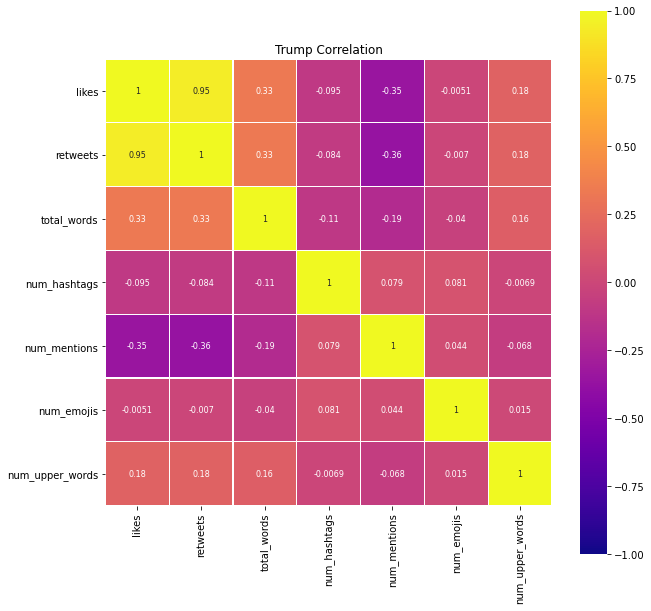

In [75]:
plt.figure(figsize=(10, 10))
plt.title('Trump Correlation')
sns.heatmap(corr_trump, 
            cmap='plasma', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

Elon also shows a similar pattern when it comes to at mentions! He should watch out when using them!

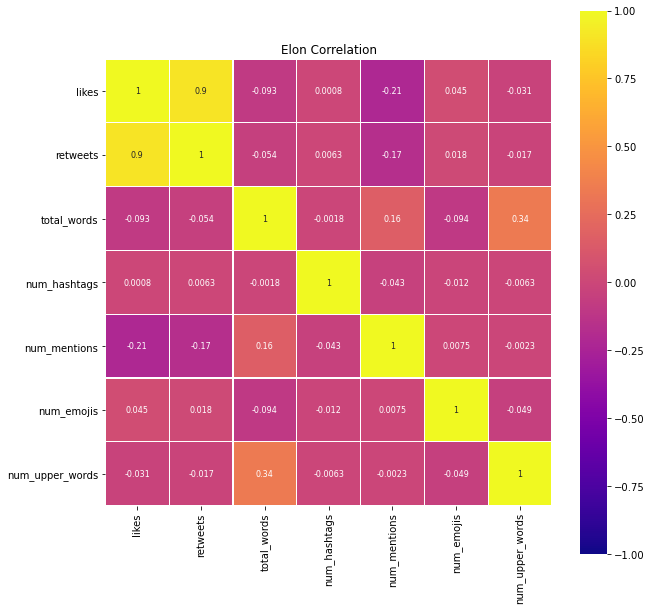

In [76]:
plt.figure(figsize=(10, 10))
plt.title('Elon Correlation')
sns.heatmap(corr_elon, 
            cmap='plasma', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

Kim usage of at mentions is of no harm, compared to Trump and Elon. This holds true also for the Pope. 

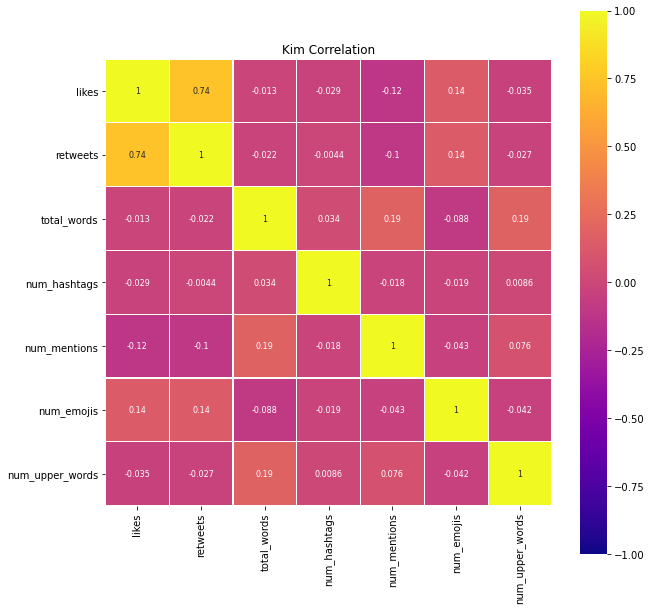

In [77]:
plt.figure(figsize=(10, 10))
plt.title('Kim Correlation')
sns.heatmap(corr_kim, 
            cmap='plasma', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

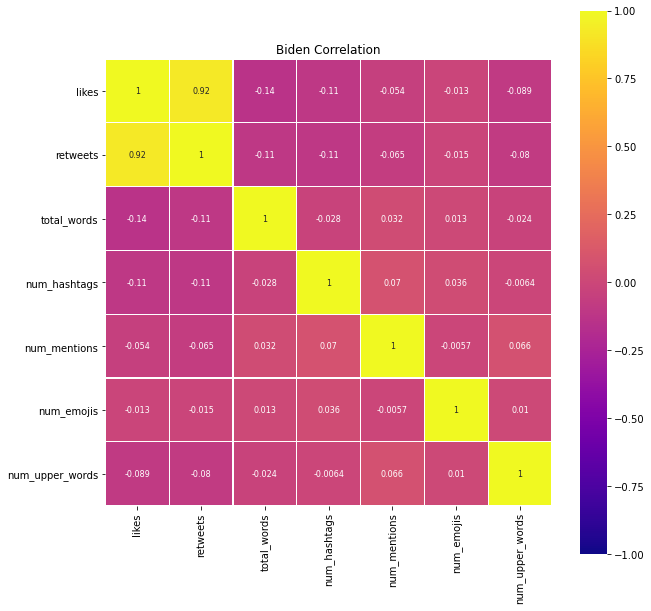

In [78]:
plt.figure(figsize=(10, 10))
plt.title('Biden Correlation')
sns.heatmap(corr_bid, 
            cmap='plasma', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

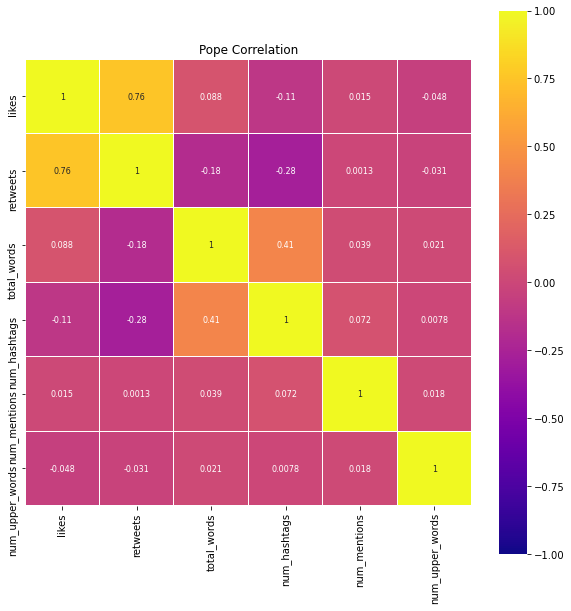

In [79]:
plt.figure(figsize=(10, 10))
plt.title('Pope Correlation')
sns.heatmap(corr_pope, 
            cmap='plasma', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

# 2. Sentiment Scoring

I am calculating **Sentiment for each Tweet** at this point. For Sentiment analysis I am using the **VADER (Valence Aware Dictionary for sEntiment Reasoning).**

Vader is based on lexicons of sentiment-related words, for which each of the words in the lexicon is rated as to whether it is positive or negative, and in many cases, how positive or negative. 

The Vader Valence score is measured on a scale from -4 to +4, where -4 stands for the most ‘Negative’ sentiment and +4 for the most ‘Positive’ sentiment. 

The midpoint 0 represents ‘Neutral’ Sentiment. When VADER analyses a piece of text it checks to see if any of the words in the text are present in the lexicon. 

I am using the VADER sentiment analytics as it is very easy to implement and it is widely used. It comes very handy because of its compound score which is is the sum of all of the lexicon ratings which have been standardised to range between -1 and 1.


In [80]:
# initiating the Vader Analyzer
vader_analyzer = SentimentIntensityAnalyzer()

df['sentiment'] = df.tweet.apply(lambda x : vader_analyzer.polarity_scores(x)['compound'])

In [81]:
df.sentiment.mean()

0.25289678904038915

Overall we can see that the sentiment of all the posts is somewhat neutral. However, this result does not take into consideration differences across personas. 

Let's deep dive a bit this preliminary finding. 

In [82]:
df.groupby('persona').sentiment.describe()

,count,mean,std,min,25%,50%,75%,max
persona,,,,,,,,
biden,6037.0,0.177658,0.549007,-0.9761,-0.1779,0.2500,0.6696,0.9825
elon,11287.0,0.202168,0.373987,-0.9638,0.0000,0.0345,0.4767,0.9983
kim,27280.0,0.320546,0.434556,-0.9686,0.0000,0.4168,0.6996,0.9997
pope,2877.0,0.452013,0.488234,-0.9573,0.1531,0.6369,0.8422,0.9891
trump,45077.0,0.222027,0.538590,-0.9829,-0.0258,0.3595,0.6892,0.9899


In general the Pope is the mostly positive tweeting persona, with a mean of compound Vader score approximately around 45. We can also see that the standard deviation is quite substantial and being overall 0.5. 

The most negative (even though it is neutral) is Biden (.17 Vader) with a std of 0.5 as well. 

In [83]:
# definining the conditions for categorizing Vader sentiment
conditions = [
    (df['sentiment'] <= -0.5),
    (df['sentiment'] > -0.5) & (df['sentiment'] < 0.5),
    (df['sentiment'] >= 0.50)
    ]

# create a list of the values we want to assign for each condition
values = ['negative', 'neutral', 'positive']

# create a new column and use np.select to assign values to it using our lists as arguments
df['sentiment_flag'] = np.select(conditions, values)

In [84]:
df.groupby(['persona', 'sentiment_flag']).sentiment_flag.size().to_frame()

sentiment_flag
persona sentiment_flag                
biden   negative                   954
        neutral                   2999
        positive                  2084
elon    negative                   434
        neutral                   8253
        positive                  2600
kim     negative                  1274
        neutral                  14104
        positive                 11902
pope    negative                   206
        neutral                    981
        positive                  1690
trump   negative                  6482
        neutral                  21102
        positive                 17493

Above we can see the distribution of sentiment per personas and the Pope is still having the highest number of positive tweets, as already noticed. 

The other personas are often tweeting with the same % both neutral and positive comments. 

I will be now looking at the positive comments and negative comments, looking at the text, to see if there is already some good insight. 

In [85]:
# dividing positive and negative sentiment
df_sentiment_positive = df[df.sentiment_flag == 'positive']
df_sentiment_negative = df[df.sentiment_flag == 'negative']

In [86]:
df_sentiment_positive.groupby('persona').sentiment.mean()

persona
biden    0.760251
elon     0.706359
kim      0.736376
pope     0.788689
trump    0.751852
Name: sentiment, dtype: float64

In [87]:
df_sentiment_negative.groupby('persona').sentiment.mean()

persona
biden   -0.749185
elon    -0.656206
kim     -0.660888
pope    -0.721745
trump   -0.716583
Name: sentiment, dtype: float64

There is not much difference if we divide the positive and the negative tweets. 

All the personas seem to be 'au-pair' and there is no winner in any of the 2 categories. 

I will try to have a look to each individual persona and their tweets. 

In [88]:
# making stop words - I will be reusing them in Topic Modelling
stop_words = list(stopwords.words('english'))
stop_words.extend(['amp', 's', 'go', 'be', 'thank', 'go', 
                   'need', 'take', 'get', 'day','make', 'come', 'much', 'guy',
                   'know', 'would', 'see', 'can', 'xo', 'soon', 'sure', 'get', 'got',
                   'look', 'am', 'pm', 'im', 'dont', 'rt', 'us']) 

Kim Kardashian Positive Tweets


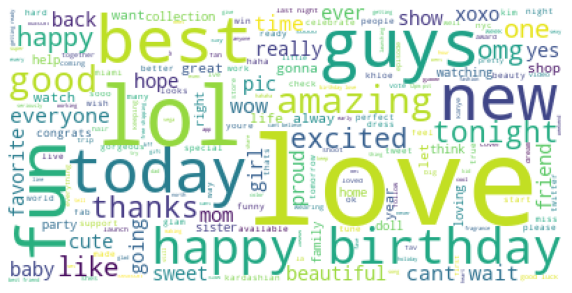

In [89]:
print('Kim Kardashian Positive Tweets')

# join tweets to a single string
kim_pos_text = ' '.join(df_sentiment_positive[df_sentiment_positive.persona == 'kim']['final'].dropna().tolist())

wordcloud = WordCloud(background_color='white', 
                     stopwords=stop_words).generate(kim_pos_text)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Kim Kardashian Negative Tweets


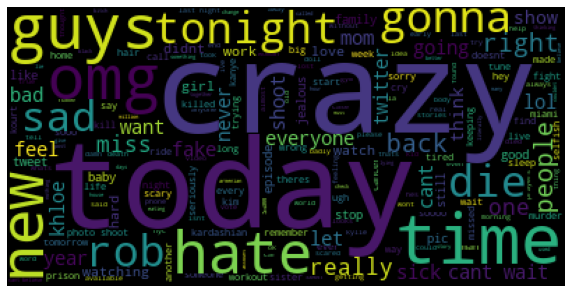

In [90]:
print('Kim Kardashian Negative Tweets')

# join tweets to a single string
kim_neg_text = ' '.join(df_sentiment_negative[df_sentiment_negative.persona == 'kim']['final'].dropna().tolist())

wordcloud = WordCloud(background_color='black', 
                     stopwords=stop_words).generate(kim_neg_text)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

We can see that when positing positive content, Kim is using a vocabulary which links to fun, love, happiness, beautiful, thank, hope, like, excitement.


When it comes to negative comments, we can see that the negative words used are hate, time, bad, rob, die. 

We can see that perhaps Vader is getting a bit confused when assessing OMG and crazy words: these words could be indeed used in a positive content (let's think about a sentence like this one: 'omg are you crazy? this present you gave me is worderful! - this is definitely positive). 

I am not going to investigate further the validity of VADER sentiment scoring, I will take the assumption that it's scoring is not often tricked by these examples. 

Despite the world cloud might not be very informative at this stage, they are definitely a helping tool when it comes to removing unwanted words in the stopword list and having an idea of what topic modelling will look like. 

Trump  Positive Tweets


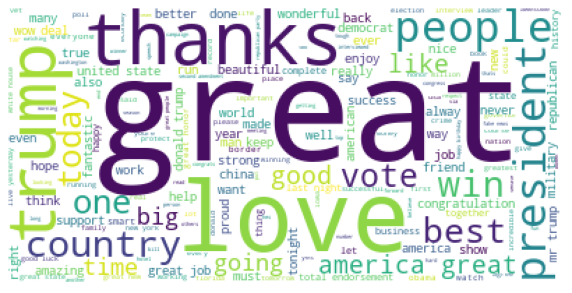

In [91]:
print('Trump  Positive Tweets')

# join tweets to a single string
trump_pos_text = ' '.join(df_sentiment_positive[df_sentiment_positive.persona == 'trump']['final'].dropna().tolist())

wordcloud = WordCloud(background_color='white', 
                     stopwords=stop_words).generate(trump_pos_text)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


Biden Positive Tweets


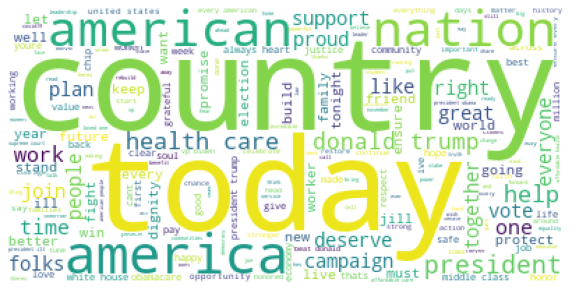

In [92]:
print('Biden Positive Tweets')

# join tweets to a single string
biden_pos_text = ' '.join(df_sentiment_positive[df_sentiment_positive.persona == 'biden']['final'].dropna().tolist())

wordcloud = WordCloud(background_color='white', 
                     stopwords=stop_words).generate(biden_pos_text)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Donald Trump and Biden when positively tweeting are using very similar wordings, despite Trump is very much focused on his mantra MAGA Make America Great Again, whereas Biden is using a softer approach by discussin about today, America, country and nation. 

When it comes to negative sentiment, there is a clear distinction. Trump is mentioning fake news, Obama, democrats and China. Biden, on the other side, is **launching direct attaks to his political opponent Trump** and its involvement in the crisis of the nation. 

Trump Negative Tweets


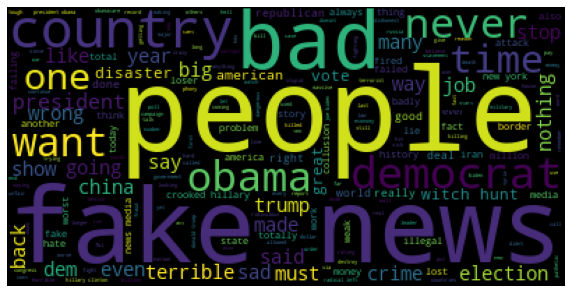

In [93]:
print('Trump Negative Tweets')

# join tweets to a single string
trump_neg_text = ' '.join(df_sentiment_negative[df_sentiment_negative.persona == 'trump']['final'].dropna().tolist())

wordcloud = WordCloud(background_color='black', 
                     stopwords=stop_words).generate(trump_neg_text)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


Biden Negative Tweets


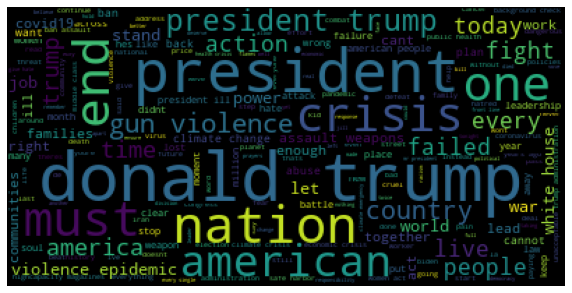

In [94]:
print('Biden Negative Tweets')

# join tweets to a single string
biden_neg_text = ' '.join(df_sentiment_negative[df_sentiment_negative.persona == 'biden']['final'].dropna().tolist())

wordcloud = WordCloud(background_color='black', 
                     stopwords=stop_words).generate(biden_neg_text)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Elon is tweeting positively about his Tesla and about cars, their model which is better/best than the other cars. 


The negative comments are not so informative, except if we look at the least used words: engine, pressure, problem, death, autopilot, fire. 

Still this vocabulary is related to the car industry. 

Elon Positive Tweets


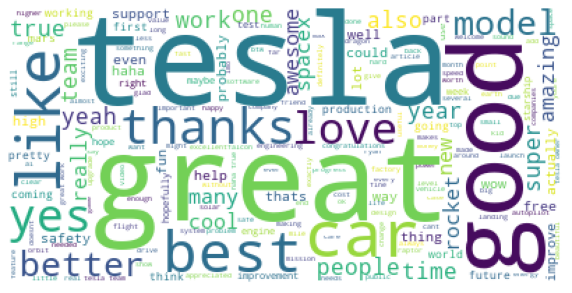

In [95]:
print('Elon Positive Tweets')

# join tweets to a single string
elon_pos_text = ' '.join(df_sentiment_positive[df_sentiment_positive.persona == 'elon']['final'].dropna().tolist())

wordcloud = WordCloud(background_color='white', 
                     stopwords=stop_words).generate(elon_pos_text)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Elon Negative Tweets


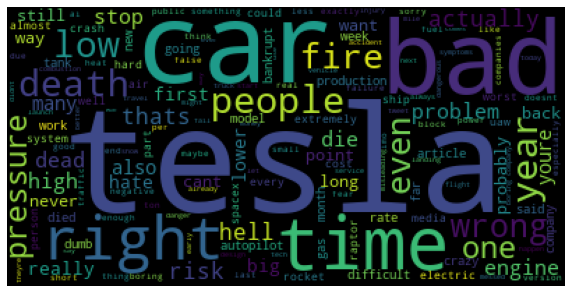

In [96]:
print('Elon Negative Tweets')

# join tweets to a single string
elon_neg_text = ' '.join(df_sentiment_negative[df_sentiment_negative.persona == 'elon']['final'].dropna().tolist())

wordcloud = WordCloud(background_color='black', 
                     stopwords=stop_words).generate(elon_neg_text)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

The Pontifex, as expected, is tweeting positively about god, love, jesus, the lord, hope, life.


Negative sentiment is coming from poverty, sufferings, violence, sickness, humanity, death, children. 

Pope Positive Tweets


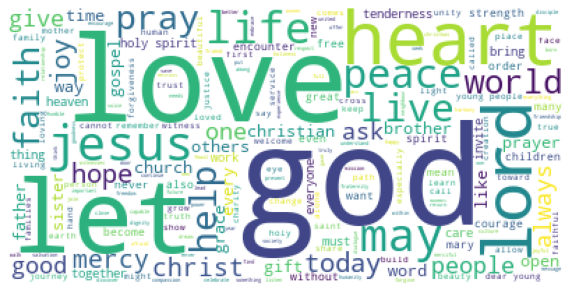

In [97]:
print('Pope Positive Tweets')

# join tweets to a single string
pope_pos_text = ' '.join(df_sentiment_positive[df_sentiment_positive.persona == 'pope']['final'].dropna().tolist())

wordcloud = WordCloud(background_color='white', 
                     stopwords=stop_words).generate(pope_pos_text)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Pope Negative Tweets


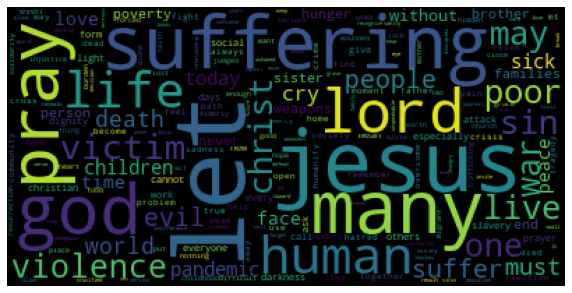

In [98]:
print('Pope Negative Tweets')

# join tweets to a single string
pope_neg_text = ' '.join(df_sentiment_negative[df_sentiment_negative.persona == 'pope']['final'].dropna().tolist())

wordcloud = WordCloud(background_color='black', 
                     stopwords=stop_words).generate(pope_neg_text)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Now that we have a first glance on the words that are mostly used by our personas, before moving into the topic modelling, I need to sample the dataset. 

# 3. Sampling

Before doing topic modelling I need to have a consistent base size for each of the personas. 

I balancing in such a way that each persona is equally probable to tweet. For this reason I need to reduce each persona's sample to the lowest one applicable. Because the Pontifex has such a low base size, I will disregard its dataset and remove it from the analysis. 

From now on my personas will be only 4: 

* Trump
* Biden
* Kim Kardashian
* Elon Musk


In [99]:
# dropping null values in the column Final - to be used for topic modelling purposes
df.dropna(subset=['final'], inplace = True)

In [100]:
# checking the distribution of tweets
df.groupby('persona')['tweet_id'].count()

persona
biden     6024
elon     10961
kim      25832
pope      2840
trump    43751
Name: tweet_id, dtype: int64

In [101]:
# sampling with the same base size of the lowest of the 4 
final_trump = df[df.persona == 'trump'].sample(n=6024, random_state=100)
final_kim = df[df.persona == 'kim'].sample(n=6024, random_state=100)
final_elon = df[df.persona == 'elon'].sample(n=6024, random_state=100)
final_biden = df[df.persona == 'biden'].copy()

In [102]:
print("Biden dataset size:", final_biden.shape)
print("Trump dataset size:", final_trump.shape)
print("Kim dataset size:", final_kim.shape)
print("Elon dataset size:", final_elon.shape)

Biden dataset size: (6024, 24)
Trump dataset size: (6024, 24)
Kim dataset size: (6024, 24)
Elon dataset size: (6024, 24)


In [103]:
# appending all datasets into a new df 
finaldf = final_biden.append(final_trump) 
finaldf = finaldf.append(final_kim)
finaldf = finaldf.append(final_elon)
print("Total Merged datasets size:", finaldf.shape)

Total Merged datasets size: (24096, 24)


In [104]:
finaldf = finaldf.to_csv('final_dataset_modelling.csv', index=False)